# Deep Learning Project - Segmenting car parts

In [ ]:
import numpy as np
import os
import torchvision
from PIL import Image
import cv2
from skimage import color
from skimage import io
from tqdm import tqdm
from glob import glob
import torch
from albumentations import CenterCrop, RandomRotate90, GridDistortion, HorizontalFlip, VerticalFlip

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Loading data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


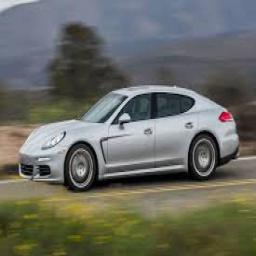

In [ ]:
from PIL import Image
import IPython.display as display

# Replace 'example_image.jpg' with the name of one of your images
img_path = '/content/drive/MyDrive/Deep Learning - Group project/carseg_data1/images/photo/no_segmentation/0001.jpg'
img = Image.open(img_path)

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformation for the images to make them into tensors
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

img_folder = '/content/drive/MyDrive/Deep Learning - Group project/carseg_data1/images/photo'

# Create a dataset
dataset = datasets.ImageFolder(root=img_folder, transform=transform)

# Create a data loader
batch_size = 32
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


torch.Size([32, 3, 256, 256])
tensor([0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
        1, 1, 1, 0, 1, 1, 1, 1])


In [ ]:
np_dir = "/content/drive/MyDrive/Deep Learning - Group project/carseg_data/arrays"
bg_dir = "/content/drive/MyDrive/Deep Learning - Group project/carseg_data/images/landscapes"

Get random background


In [ ]:
def get_random_bg():
    bg_dir = "/content/drive/MyDrive/Deep Learning - Group project/carseg_data/images/landscapes"
    bgs_path = os.listdir(bg_dir)
    while True:
        idx = np.random.randint(low=0, high=len(bgs_path))
        bg_path = os.path.join(bg_dir,bgs_path[idx])
        bg = cv2.imread(bg_path)
        resized_bg = cv2.resize(bg,(np_img.shape[1], np_img.shape[2]), interpolation = cv2.INTER_AREA)
        return resized_bg

Image augmentation

In [ ]:
def augment_data(img):

    H = 256
    W = 256

    x = np.transpose(img[:3]*255,(1,2,0)).astype(np.uint8)
    y = img[3]

    np.random.seed(0)
    mod = np.random.randint(low=0, high=5)

    if mod==0:
        aug = CenterCrop(H, W, p=1.0)
        augmented = aug(image=x, mask=y)
        x_aug = augmented["image"]
        y_aug = augmented["mask"]

    if mod==1:
        aug = RandomRotate90(p=1.0)
        augmented = aug(image=x, mask=y)
        x_aug = augmented['image']
        y_aug = augmented['mask']

    if mod==2:
        aug = GridDistortion(p=1.0)
        augmented = aug(image=x, mask=y)
        x_aug = augmented['image']
        y_aug = augmented['mask']

    if mod==3:
        aug = HorizontalFlip(p=1.0)
        augmented = aug(image=x, mask=y)
        x_aug = augmented['image']
        y_aug = augmented['mask']

    if mod==4:
        aug = VerticalFlip(p=1.0)
        augmented = aug(image=x, mask=y)
        x_aug = augmented['image']
        y_aug = augmented['mask']

    i = cv2.resize(x_aug, (W, H))
    i = np.transpose(i/255,(2,0,1))
    m = cv2.resize(y_aug, (W, H))
    m = np.reshape(m,(1,256,256))
    res = np.concatenate((i,m),axis=0)

    return res,mod

In [ ]:
def get_file(dir):
    listOfFile = os.listdir(dir)
    allFiles = []
    for entry in listOfFile:
        fullPath = os.path.join(dir, entry)
        allFiles.append(fullPath)
    return allFiles

Add random background and one type of data augmentation

In [ ]:
nps_path = os.listdir(np_dir)
for np_path in tqdm(nps_path):
    np_img = np.load(os.path.join(np_dir,np_path))
    bg = get_random_bg()
    np_img[:3] *= 255
    for i in range(np_img.shape[0]):
     for j in range(np_img.shape[1]):
        if np_img[i, j, 3] == 0:
            np_img[i, j, 0] = bg[i % bg.shape[0], j, 0]
            np_img[i, j, 1] = bg[i % bg.shape[0], j, 1]
            np_img[i, j, 2] = bg[i % bg.shape[0], j, 2]
    np_img[:, :, :3] = (np_img[:, :, :3] / 255).astype(np.uint8)
    res,mod = augment_data(np_img)
    name = os.path.join(np_dir,np_path)[:-4]+"_aug_"+str(mod)+".npy"
    np.save(name,res)

100%|██████████| 3004/3004 [37:22<00:00,  1.34it/s]
